# CYGNSS Streamflow Modeling for Ungauged Basins (CSMUB)

This code combines the delineation of watersheds and the analysis of the CYGNSS watermask files to determine the surface water extent of each basin on a monthly time scale using the functions `crop_dem`, `process_basin` and `waterpx_count`. In addition, the function `read_gauge` loads the empirical streamflow data from text files downloaded from the Global Runoff Data Centre (GRDC) [link text](https://portal.grdc.bafg.de/applications/public.html?publicuser=PublicUser#dataDownload/Home). Lastly, it outputs a .csv file with the station name and the results of the analysis.

---


Author(s): Anna Valcarcel

Date of Creation: May 30, 2024

Last Updated: November 19, 2024

Version History:
*   v0.00 - Initial Version taken from demo codes
*   v0.01 - Added data visualization and functionality for reading GRDC data
*   v0.02 - Added .txt file readability for station date, functionality for downloading graphics/plots, and location details within plots.

*   v1.00 - Added functionality for loading station masterfile, cropping continent-scale DEM files, and calculating intersection of delineated and GRDC shape files to determine which shp to use





## Importing Packages

In [1]:
# !pip install pysheds netCDF4 fiona geopandas xarray pyshp

In [2]:
# IMPORT PACKAGES
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
import shapefile
import os

import netCDF4 as nc
import geopandas as gpd
import numpy as np
from affine import Affine  # Fix the missing import
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import box

## Define Functions

### Crop NetCDF to Shape

In [3]:
def netcdf_totif(netcdf, shp_input, output_tif):

    # Load NetCDF file and extract variables
    with nc.Dataset(netcdf) as dataset:
        watermask = dataset.variables['watermask'][:]
        latitude = dataset.variables['lat'][:]
        longitude = dataset.variables['lon'][:]
    
    # Load and reproject the shapefile
    shp = gpd.read_file(shp_input).to_crs('EPSG:4326')
    
    # Clip NetCDF data to shapefile bounding box
    minlon, minlat, maxlon, maxlat = shp.geometry.total_bounds
    lat_mask = (latitude >= minlat) & (latitude <= maxlat)
    lon_mask = (longitude >= minlon) & (longitude <= maxlon)
    
    watermask = watermask[lat_mask, :][:, lon_mask]
    lat_filtered = latitude[lat_mask]
    lon_filtered = longitude[lon_mask]
    
    # Create a mask based on shapefile geometry
    transform = Affine(
        (lon_filtered[-1] - lon_filtered[0]) / len(lon_filtered), 0, lon_filtered[0],
        0, (lat_filtered[-1] - lat_filtered[0]) / len(lat_filtered), lat_filtered[0]
    )
    
    shapes = [geom for geom in shp.geometry]
    mask = geometry_mask(shapes, transform=transform, invert=True, out_shape=watermask.shape)
    
    # Apply mask to the watermask
    filtered_watermask = np.where(mask, watermask, np.nan)

    # Export to GeoTIFF
    with rasterio.open(
        output_tif,
        'w',
        driver='GTiff',
        height=filtered_watermask.shape[0],
        width=filtered_watermask.shape[1],
        count=1,
        dtype=filtered_watermask.dtype,
        crs='EPSG:4326',
        transform=transform,
    ) as dst:
        dst.write(filtered_watermask, 1)


## Define Filepaths and Open Station Masterfile


In [4]:
# DEFINE INPUTS FOR FUNCTION
masterlist = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/ALL_STATIONS_FINAL.csv'

In [5]:
stations_df = pd.read_csv(masterlist)
# print(stations_df)
# station_num = stations_df['grdc_no']
# # station_num

In [6]:
# monthly_path = '/global/scratch/users/arvalcarcel/CSMUB/DATA/STATIONS/'

# station_files = [os.path.join(monthly_path, f"{station_no}_Q_Month.txt") for station_no in station_num]

# shp_log = np.zeros(len(station_files))

# print(f"Loaded {len(station_files)} stations.")

## Loop Through All Stations

In [7]:
# for i in range(0):
i = 0
data = stations_df.iloc[i]
# print(data)
number = data['grdc_no']
region = data['wmo_reg']
river = data['river']
name = data['station']
lat = data['lat']
lon = data['long']
area = data['area']
altitude = data['altitude']
shp_code = data['shapefile_code']

print(number)
print(region)
print(name)
print(lon,lat)

1159100
1
VIOOLSDRIF (27811003)
17.72159144 -28.75798997


### Determine Shapefile for Use

In [8]:
# CHOOSE SHAPEFILE BASED ON CODE

# Define the path for the new folder
new_folder_path = f'/global/scratch/users/arvalcarcel/CSMUB/DATA/DEM/STATIONS/{number}/'

# Create new shapefile
shp_name = new_folder_path + f'{number}.shp'

if shp_code == 1:
    shapefile = shp_name
elif shp_code == 2:
    shapefile = f'/global/scratch/users/arvalcarcel/CSMUB/DATA/DEM/STATIONS/{number}/{number}.shp'

In [9]:
# # Load and reproject shapefile
# shp = gpd.read_file(shapefile).to_crs('EPSG:4326')

# # Plot using GeoPandas
# shp.plot(figsize=(4,4), color='blue', edgecolor='black')
# plt.title("Shapefile Visualization (EPSG:4326)")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()

### Get Streamflow Data

In [10]:
csv_name = f'/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/{number}.csv'
station_result = pd.read_csv(csv_name)
dates = station_result['Date']

### Calculate Water Pixel Percent

In [11]:
# assign directory
directory = "/global/scratch/users/arvalcarcel/CSMUB/DATA/CYGNSS/"
file_list = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

In [12]:
ncdf_list = []

for i in range(0,len(dates)):
    date = dates[i]
    ncdf_name = f'/global/scratch/users/arvalcarcel/CSMUB/DATA/CYGNSS/cyg.ddmi.{date}.l3.uc-berkeley-watermask-monthly.a31.d32.nc'
    ncdf_list.append(ncdf_name)

In [13]:
# THIS ONE WORKS
for f, filename in enumerate(ncdf_list):
  if os.path.isfile(filename):
    # Define the path for the new folder
    new_folder_path = f'/global/scratch/users/arvalcarcel/CSMUB/RESULTS/MONTHLY_TIF/{number}/'
    # Create the folder
    os.makedirs(new_folder_path, exist_ok=True)
    
    # Create new shapefile
    tif_out = new_folder_path + f'{number}_watermask_' + dates[f] + '.tif'
    print(tif_out)
    netcdf_totif(filename,shapefile,tif_out)

/global/scratch/users/arvalcarcel/CSMUB/RESULTS/MONTHLY_TIF/1159100/1159100_watermask_2018-08.tif
/global/scratch/users/arvalcarcel/CSMUB/RESULTS/MONTHLY_TIF/1159100/1159100_watermask_2018-09.tif
/global/scratch/users/arvalcarcel/CSMUB/RESULTS/MONTHLY_TIF/1159100/1159100_watermask_2018-10.tif
/global/scratch/users/arvalcarcel/CSMUB/RESULTS/MONTHLY_TIF/1159100/1159100_watermask_2018-11.tif
/global/scratch/users/arvalcarcel/CSMUB/RESULTS/MONTHLY_TIF/1159100/1159100_watermask_2018-12.tif
/global/scratch/users/arvalcarcel/CSMUB/RESULTS/MONTHLY_TIF/1159100/1159100_watermask_2019-01.tif
/global/scratch/users/arvalcarcel/CSMUB/RESULTS/MONTHLY_TIF/1159100/1159100_watermask_2019-02.tif
/global/scratch/users/arvalcarcel/CSMUB/RESULTS/MONTHLY_TIF/1159100/1159100_watermask_2019-03.tif
/global/scratch/users/arvalcarcel/CSMUB/RESULTS/MONTHLY_TIF/1159100/1159100_watermask_2019-04.tif
/global/scratch/users/arvalcarcel/CSMUB/RESULTS/MONTHLY_TIF/1159100/1159100_watermask_2019-05.tif
/global/scratch/user

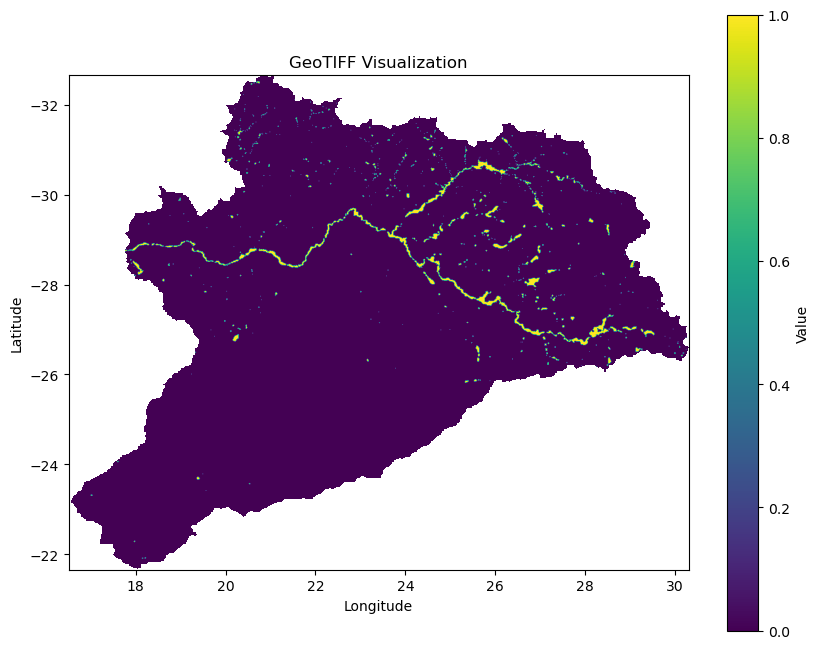

In [14]:
def visualize_tif(tif_path):
    """
    Function to visualize a GeoTIFF file.
    
    Parameters:
    - tif_path: Path to the GeoTIFF file.
    """
    with rasterio.open(tif_path) as src:
        # Read the first band of the raster
        data = src.read(1)
        # Get the metadata
        bounds = src.bounds
        extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

        # Plot the raster
        plt.figure(figsize=(10, 8))
        plt.imshow(data, extent=extent, cmap='viridis', origin='upper')
        plt.colorbar(label='Value')
        plt.title('GeoTIFF Visualization')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

# Call the visualization function
visualize_tif(tif_out)
